In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [18]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *
from jtb_2022_code.utils.decay_common import calc_decays, calc_halflives, calc_decay_windows, _halflife
from jtb_2022_code import FigureSingleCellData
from inferelator_prior.velocity import decay
import numpy as np
import pandas as pd

In [2]:
## LOAD AND PROCESS VELOCITY AND DECAY ###
data = FigureSingleCellData()

data.apply_inplace_to_expts(calculate_times_velocities, 
                            layer='denoised',
                            transform_expr=np.expm1,
                            distance_key='denoised_distances')

data.apply_inplace_to_expts(calc_decays)
data.apply_inplace_to_expts(calc_halflives)
data.apply_inplace_to_expts(calc_decay_windows, 80)

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


  0%|          | 0/80 [00:00<?, ?it/s]/home/cj59/repos/inferelator-prior/inferelator_prior/velocity/decay.py:139: RuntimeWarning: Mean of empty slice
  mse_x = np.sum(np.square(x - np.nanmean(x)))
100%|██████████| 80/80 [01:30<00:00,  1.14s/it]


In [3]:
data.expt_data[(1, "WT")].varm['decay_windows'].shape

(5747, 80)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats

<ipython-input-18-9feab0742089>:12: RuntimeWarning: divide by zero encountered in true_divide
  hl = np.log(2) / decay_constants
<ipython-input-18-9feab0742089>:12: RuntimeWarning: divide by zero encountered in true_divide
  hl = np.log(2) / decay_constants
<ipython-input-18-9feab0742089>:12: RuntimeWarning: divide by zero encountered in true_divide
  hl = np.log(2) / decay_constants
<ipython-input-18-9feab0742089>:12: RuntimeWarning: divide by zero encountered in true_divide
  hl = np.log(2) / decay_constants
<ipython-input-18-9feab0742089>:12: RuntimeWarning: divide by zero encountered in true_divide
  hl = np.log(2) / decay_constants


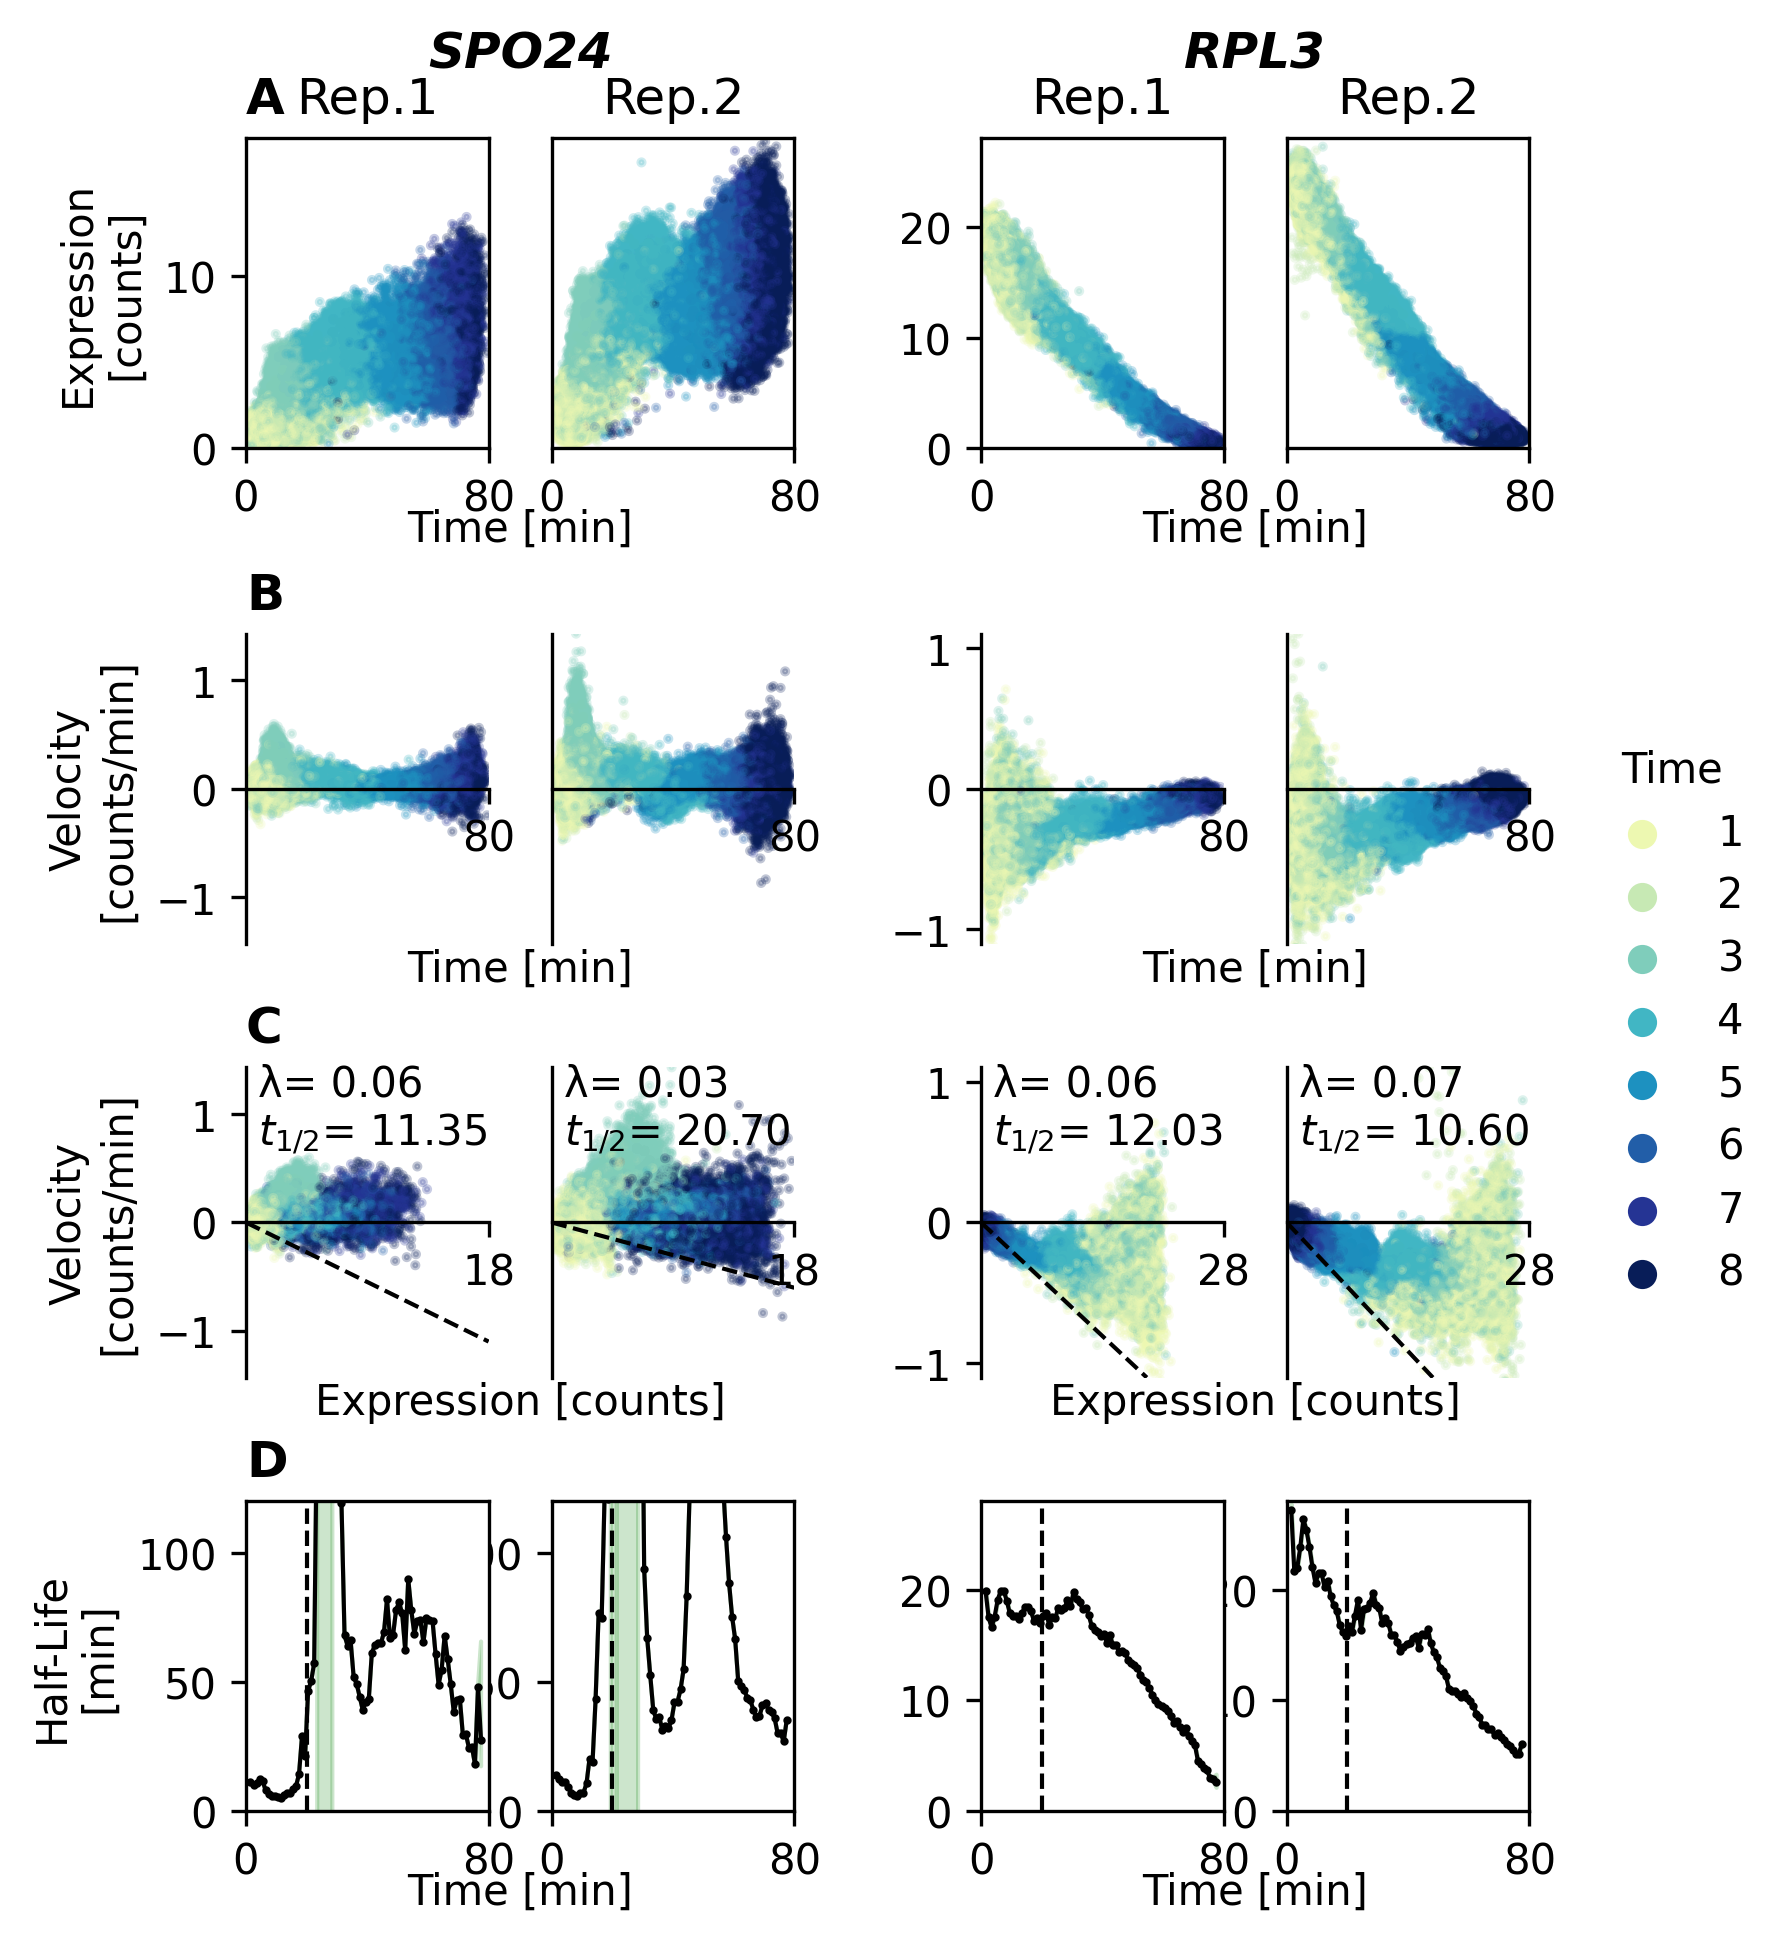

In [38]:
rgen = np.random.default_rng(100)

panel_genes = ["YPR036W-A", "YOR063W"]

panel_labels = {'expr_11': "A",
                'velocity_11': "B",
                'decay_11': "C",
                'decaytime_11': "D"}

panel_titles = {'title_1': "SPO24",
                'title_2': "RPL3"}

x_axis_labelers = {'x_lab_11': ('Time [min]', 0), 
                   'x_lab_21': ('Time [min]', 0.9), 
                   'x_lab_31': ('Expression [counts]', 0.9), 
                   'x_lab_12': ('Time [min]', 0), 
                   'x_lab_22': ('Time [min]', 0.9), 
                   'x_lab_32': ('Expression [counts]', 0.9),
                   'x_lab_41': ('Time [min]', 0),
                   'x_lab_42': ('Time [min]', 0)}

layout = [['title_1', 'title_1', '.', 'title_2', 'title_2', '.'],
          ['expr_11', 'expr_21', '.', 'expr_12', 'expr_22', 'time_lgd'],
          ['x_lab_11', 'x_lab_11', '.', 'x_lab_12', 'x_lab_12', 'time_lgd'],
          ['.'] * 5 + ['time_lgd'],
          ['velocity_11', 'velocity_21', '.', 'velocity_12', 'velocity_22', 'time_lgd'],
          ['x_lab_21', 'x_lab_21', '.', 'x_lab_22', 'x_lab_22', 'time_lgd'],
          ['decay_11', 'decay_21', '.', 'decay_12', 'decay_22', 'time_lgd'],
          ['x_lab_31', 'x_lab_31', '.', 'x_lab_32', 'x_lab_32', 'time_lgd'],
          ['decaytime_11', 'decaytime_21', '.', 'decaytime_12', 'decaytime_22', 'time_lgd'],
          ['x_lab_41', 'x_lab_41', '.', 'x_lab_42', 'x_lab_42', 'time_lgd']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 1, 0.25, 1, 1, 0.2], 
                                               height_ratios=[0.05, 1, 0.2, 0.1, 1, 0.2, 1, 0.2, 1, 0.2],
                                               wspace=0.35), 
                              figsize=(6, 8), dpi=300)

def _minmax(arr):
    return np.nanmin(arr), np.nanmax(arr)

def _minmax_list(lst):
    return min(l[0] for l in lst), max(l[1] for l in lst)

def _get_limits(layer, mod_func=lambda x: x, symmetric=False):
    limits = {g: _minmax_list([_minmax(mod_func(data.expt_data[(j, k)].layers[layer][:, data.expt_data[(j, k)].var_names == g])) 
                              for j in range(1, 3) 
                              for k in ["WT"]]) 
              for g in panel_genes}
    
    if not symmetric:
        return {g: (np.floor(v[0]), np.ceil(v[1])) for g, v in limits.items()}
    else:
        return {g: (-1 * np.max(v), np.max(v)) for g, v in limits.items()}
    
def _get_halflife_limits(decay_key='decay_windows', se_key='decay_windows_se', max_halflife=120):
    limits = {g: _minmax_list([_minmax(_halflife(data.expt_data[(j, k)].varm[decay_key][data.expt_data[(j, k)].var_names == g, :].flatten() -
                                                 data.expt_data[(j, k)].varm[se_key][data.expt_data[(j, k)].var_names == g, :].flatten()))
                             for j in range(1, 3) 
                             for k in ["WT"]]) for g in panel_genes}
    return {g: (0, np.ceil(min(max_halflife, v[1]))) for g, v in limits.items()}

expr_limits = _get_limits('denoised', mod_func = np.expm1)
velocity_limits = _get_limits('denoised_velocity', symmetric=True)
halflife_limits = _get_halflife_limits()

for a in ['title_1', 'title_2', 'time_lgd']:
    axd[a].axis('off')
    
for axid, (lab, yoff) in x_axis_labelers.items():
    axd[axid].axis('off')
    axd[axid].annotate(lab, (0.5, yoff), xycoords='axes fraction', ha='center')

def _replot_axes(ax):
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
               
for j in range(1, 3):
    pdata = data.expt_data[(j, "WT")]
    for i, g in enumerate(panel_genes):
        g_idx = pdata.var_names == g
        
        overplot_shuffle = np.arange(pdata.shape[0])
        rgen.shuffle(overplot_shuffle)
        
        time_data = pdata.obs['time_pca_pt'].values[overplot_shuffle]
        expr_data = np.expm1(pdata.layers['denoised'][:, g_idx]).flatten()[overplot_shuffle]
        velocity_data = pdata.layers['denoised_velocity'][:, g_idx].flatten()[overplot_shuffle]
        color_data = pdata.obs['Pool'].map({k: v for k, v in zip(range(1, 9), pool_palette())}).values[overplot_shuffle]
        
        ### PANEL A ###
        a_ref = "expr_" + str(j) + str(i + 1)
        fig_refs[a_ref] = axd[a_ref].scatter(x=time_data, 
                                             y=expr_data,
                                             c=color_data,
                                             alpha=0.25, 
                                             s=2)
        axd[a_ref].set_xlim(0, 80)
        axd[a_ref].set_xticks([0, 80])
        axd[a_ref].set_ylim(*expr_limits[g])
        axd[a_ref].set_yticks([]) if j == 2 else None
        axd[a_ref].set_ylabel("Expression\n[counts]") if j == 1 and i == 0 else None
        axd[a_ref].set_title("Rep." + str(j))
        
        ### PANEL B ###
        b_ref = "velocity_" + str(j) + str(i + 1)
        fig_refs[b_ref] = axd[b_ref].scatter(x=time_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.25, 
                                             s=2)
        
        axd[b_ref].set_xlim(0, 80)
        axd[b_ref].set_xticks([80])
        axd[b_ref].set_ylim(*velocity_limits[g])
        axd[b_ref].set_yticks([]) if j == 2 else None
        axd[b_ref].set_ylabel("Velocity\n[counts/min]") if j == 1 and i == 0 else None

        _replot_axes(axd[b_ref])
        
        ### PANEL C ###
        c_ref = "decay_" + str(j) + str(i + 1)
        fig_refs[c_ref] = axd[c_ref].scatter(x=expr_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.25, 
                                             s=2)
        
        axd[c_ref].set_xlim(*expr_limits[g])
        axd[c_ref].set_xticks([expr_limits[g][1]])
        axd[c_ref].set_ylim(*velocity_limits[g])
        axd[c_ref].set_yticks([]) if j == 2 else None
        axd[c_ref].set_ylabel("Velocity\n[counts/min]") if j == 1 and i == 0 else None

        _replot_axes(axd[c_ref])
        
        decay_constant = pdata.var.loc[g_idx, 'decay'][0]
        half_life = np.log(2) / decay_constant
        axd[c_ref].axline((0, 0), slope = -1 * decay_constant, c="black", linestyle='--', linewidth=1.0)
        axd[c_ref].annotate(f"λ= {decay_constant:.2f}\n" + "$t_{1/2}$= " + f"{half_life:.2f}", 
                            xy=(5, 0.2),  xycoords='data', xytext=(0.05, 0.75), textcoords='axes fraction')
        
        ### PANEL D ###
        d_ref = "decaytime_" + str(j) + str(i + 1)
        times = pdata.uns['decay_windows']['times']
        decays = pdata.varm['decay_windows'][g_idx, :].flatten()
        decays_ci = pdata.varm['decay_windows_se'][g_idx, :].flatten() * 1.96
        
        axd[d_ref].plot(times, _halflife(decays), marker=".", linestyle='-', linewidth=1.0, markersize=2, c='black')
        axd[d_ref].set_xlim(0, 80)
        axd[d_ref].set_xticks([0, 80])
        axd[d_ref].set_ylim(*halflife_limits[g])
        
        axd[d_ref].fill_between(times, _halflife(decays + decays_ci), _halflife(decays - decays_ci), alpha=0.2, color='green')
        
        axd[d_ref].axvline(20, 0, 1, linestyle='--', linewidth=1.0, c='black')
        axd[d_ref].set_ylabel("Half-Life\n[min]") if j == 1 and i == 0 else None
        
fig_refs['time_lgd'] = add_legend(axd['time_lgd'], 
                                  pool_palette(), 
                                  data.all_data.obs['Pool'].dtype.categories.values,
                                  title="Time")

### Half-life correlation plot ###
"""
hl_x = data.expt_data[(1, "WT")].var['halflife']
hl_y = data.expt_data[(2, "WT")].var['halflife']
drop_na_idx = hl_x.isna() | hl_y.isna()
hl_x = hl_x.loc[~drop_na_idx]
hl_y = hl_y.loc[~drop_na_idx]

hl_rho = scipy.stats.spearmanr(hl_x, hl_y)[0]
fig_refs['hl_corr'] = axd['hl_corr'].scatter(x=hl_x, y=hl_y, 
                                             c='black', alpha=0.2, marker='.')
axd['hl_corr'].set_xlabel("Expt 1. $t_{1/2}$ [min]")
axd['hl_corr'].set_ylabel("Expt 2. $t_{1/2}$ [min]")
axd['hl_corr'].set_xlim(0, 20)
axd['hl_corr'].set_ylim(0, 20)
axd['hl_corr'].axline((0, 0), slope = 1, c='red', linestyle='--', linewidth=1.0)
axd['hl_corr'].annotate(f"ρ= {hl_rho:.2f}",
                        xy=(5, 0.2),  xycoords='data', xytext=(0.45, 0.05), textcoords='axes fraction')

# Half-life correlation / time plots
"""

for ax_id, label in panel_titles.items():
    axd[ax_id].set_title(label, fontdict={'fontweight': 'bold', 'fontstyle': 'italic'})

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(label, loc='left', weight='bold')
    
#fig.savefig(FIGURE_3_FILE_NAME + ".png", facecolor='white')
        

In [35]:
g_idx = 
times = pdata.uns['decay_windows']['times']
decays = pdata.varm['decay_windows'][g_idx, :].flatten()
decays_se = pdata.varm['decay_windows_se'][g_idx, :].flatten()

In [36]:
_halflife(decays + decays_se)

<ipython-input-18-9feab0742089>:12: RuntimeWarning: divide by zero encountered in true_divide
  hl = np.log(2) / decay_constants


array([        nan, 26.76472619, 21.50309673, 21.95644534, 23.86700383,
       26.36377038, 25.38555952, 23.84815151, 22.00388024, 20.53977296,
       21.48700005, 21.48258701, 20.14108265, 20.76206205, 19.34218117,
       18.52082759, 17.99423014, 16.71291671, 16.11610885, 15.79391941,
       16.6997809 , 16.11809595, 17.62255682, 19.0498364 , 16.32059371,
       18.11066436, 18.23060906, 18.70950929, 19.68086571, 18.54988803,
       18.29298406, 16.92605864, 17.43363275, 16.94264761, 15.8905146 ,
       15.86089978, 15.27413234, 14.42902707, 14.85384064, 15.11953968,
       15.18304886, 15.63694442, 15.82724867, 14.75597346, 16.02258737,
       15.93148727, 16.46623362, 15.16475088, 14.33017244, 13.88728979,
       12.9718132 , 12.63772368, 12.18313152, 11.00787483, 10.87465617,
       10.81469682, 10.53859275, 10.29996947, 10.66672137, 10.20128267,
        9.90587692,  9.50602404,  8.81109617,  8.4882327 ,  7.76127356,
        7.78568098,  7.45187535,  7.37667601,  6.87567233,  7.03

In [41]:
decays_se

array([0.00000000e+00, 4.43278435e-04, 2.79278756e-04, 3.60596180e-05,
       5.43454425e-06, 3.66200554e-06, 4.74723738e-06, 5.41286792e-06,
       1.04738698e-05, 2.63085023e-05, 3.94586732e-05, 1.77207050e-05,
       1.10785802e-04, 9.93416943e-05, 8.67964846e-05, 1.30523779e-04,
       7.79834212e-05, 1.94605722e-04, 1.17764576e-04, 1.75380599e-04,
       1.18194303e-04, 9.55603961e-05, 8.33605167e-05, 9.45348405e-05,
       1.28933839e-04, 3.58542317e-04, 2.57941503e-04, 1.24999540e-04,
       8.89934661e-05, 7.33275716e-05, 1.17529342e-04, 8.02370143e-05,
       4.29137747e-05, 4.33253289e-05, 2.86689542e-05, 4.04358060e-05,
       2.22569867e-05, 2.15879527e-05, 1.48545293e-05, 1.83715595e-05,
       1.24570964e-05, 3.65277831e-05, 4.84928016e-05, 1.60292282e-05,
       2.04802909e-05, 1.40435896e-05, 3.46449232e-06, 4.71253056e-06,
       4.07391307e-06, 6.09314345e-06, 3.78767476e-06, 4.85985510e-06,
       3.66179671e-06, 6.83659290e-06, 7.90906201e-06, 7.43540921e-06,
      

In [37]:
_halflife(decays - decays_se)

<ipython-input-18-9feab0742089>:12: RuntimeWarning: divide by zero encountered in true_divide
  hl = np.log(2) / decay_constants


array([        nan, 27.7134381 , 21.88226831, 22.00671929, 23.87593947,
       26.37111653, 25.39438971, 23.85703745, 22.0185222 , 20.57184818,
       21.5396942 , 21.50621006, 20.27159735, 20.88636155, 19.43633249,
       18.65092087, 18.06738369, 16.87124537, 16.20484987, 15.92116739,
       16.79543489, 16.1900482 , 17.69757172, 19.14934062, 16.42029213,
       18.45646668, 18.48137071, 18.83661887, 19.78083149, 18.62297876,
       18.40717259, 16.99264667, 17.47134787, 16.97860845, 15.91142987,
       15.89030543, 15.28912954, 14.44200725, 14.86330339, 15.13166731,
       15.19133928, 15.66275798, 15.86237684, 14.76605088, 16.03777246,
       15.9417787 , 16.46894446, 15.16787853, 14.33258675, 13.89068125,
       12.97365245, 12.63996365, 12.18469998, 11.01026564, 10.87735558,
       10.81720662, 10.54131697, 10.30224606, 10.66992495, 10.20398147,
        9.90892171,  9.50823464,  8.81387789,  8.4899169 ,  7.76438173,
        7.78900223,  7.45518817,  7.38033324,  6.87901471,  7.03